## Extract the data 
Need to download the data.zip from https://huggingface.co/datasets/Writer/omniact/tree/main

In [1]:
# import os
# import zipfile
# from pathlib import Path

# def extract_zip_data(zip_path: str, extract_path: str | None = None) -> None:
#     """
#     Extract contents of a zip file to specified directory.
    
#     Parameters
#     ----------
#     zip_path : str
#         Path to the zip file to extract
#     extract_path : str or None, optional
#         Directory to extract files to. If None, extracts to same directory as zip file.
        
#     Raises
#     ------
#     FileNotFoundError
#         If zip file does not exist
#     zipfile.BadZipFile
#         If file is not a valid zip file
#     """
#     zip_path = Path(zip_path)
    
#     if not zip_path.exists():
#         raise FileNotFoundError(f"Zip file not found at {zip_path}")
        
#     if extract_path is None:
#         extract_path = zip_path.parent
        
#     # Create extraction directory if it doesn't exist
#     os.makedirs(extract_path, exist_ok=True)
    
#     try:
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#             print(f"Successfully extracted files to {extract_path}")
#     except zipfile.BadZipFile:
#         raise zipfile.BadZipFile(f"File {zip_path} is not a valid zip file")

# # Extract the data
# zip_path = "/teamspace/studios/this_studio/dsim/Data/UI_3_data/data.zip"
# extract_zip_data(zip_path)


## Preprocessing dataset

In [2]:
import os
import re
import json
from pathlib import Path
from typing import Optional, Tuple, Any, Dict, List

import pandas as pd


def parse_task_file(task_file: str) -> Optional[Tuple[str, Tuple[float, float]]]:
    """
    Parse a task file to extract the task description and the first pyautogui.click coordinates.

    The function looks for a line starting with "Task:" to obtain the task description and then
    searches the output script (after the "Output Script:" marker) for the first non-empty action.
    If the first non-empty action does not start with "pyautogui.click(", or if no such action is found,
    the function returns None.

    Parameters
    ----------
    task_file : str
        Path to the task file.

    Returns
    -------
    tuple or None
        If valid, returns a tuple (task_description, (click_x, click_y)).
        Returns None if the task description is missing or the first action is not a pyautogui.click.
    """
    try:
        with open(task_file, "r", encoding="utf-8") as f:
            content = f.read()
    except Exception as e:
        print(f"Error reading task file {task_file}: {e}")
        return None

    lines = content.splitlines()
    task_description: Optional[str] = None
    output_script_lines: List[str] = []
    in_output = False

    for line in lines:
        if line.startswith("Task:"):
            # Extract the task description
            task_description = line[len("Task:"):].strip()
        if line.startswith("Output Script:"):
            in_output = True
            # Include any text on the same line after the colon
            remainder = line[len("Output Script:"):].strip()
            if remainder:
                output_script_lines.append(remainder)
            continue
        if in_output:
            output_script_lines.append(line.strip())

    if task_description is None:
        # No task description found, skip this task file.
        return None

    # Find the first non-empty line in the output script.
    first_action: Optional[str] = None
    for action in output_script_lines:
        if action:
            first_action = action
            break

    if first_action is None:
        return None

    # Ensure the first action is a pyautogui.click call.
    if not first_action.startswith("pyautogui.click("):
        return None

    # Use regex to extract the coordinates within pyautogui.click(...)
    pattern = r"pyautogui\.click\(\s*([\d\.]+)\s*,\s*([\d\.]+)\s*\)"
    match = re.search(pattern, first_action)
    if not match:
        return None

    try:
        click_x = float(match.group(1))
        click_y = float(match.group(2))
        return task_description, (click_x, click_y)
    except ValueError:
        return None


def click_within_box(click: Tuple[float, float], box: Dict[str, Any]) -> bool:
    """
    Check if a click coordinate falls within a given bounding box.

    Parameters
    ----------
    click : tuple of float
        The (x, y) coordinates of the click.
    box : dict
        A dictionary representing a bounding box. Expected keys are 'top_left' and 'bottom_right',
        each containing a list with two numeric elements [x, y].

    Returns
    -------
    bool
        True if the click is within the bounding box, False otherwise.
    """
    x, y = click
    top_left = box.get("top_left")
    bottom_right = box.get("bottom_right")
    if not (top_left and bottom_right):
        return False
    return top_left[0] <= x <= bottom_right[0] and top_left[1] <= y <= bottom_right[1]


def create_database(data_root: str, num_folders: int = 10) -> pd.DataFrame:
    """
    Create a database in the form of a single DataFrame by aggregating data from screenshot images,
    bounding boxes metadata, and task files.

    Parameters
    ----------
    data_root : str
        The root directory where the data is stored.
        Expected to contain the following subdirectories:
          - data/data/web for screenshots,
          - data/metadata/web/boxes for bounding boxes,
          - data/tasks/web for task files.

    For each of the first 10 folders in the screenshot root, the function:
      - Reads screenshot images from "<data_root>/data/data/web/<folder>".
      - Loads the corresponding bounding boxes from "<data_root>/data/metadata/web/boxes/<folder>" with the naming
        convention "screen<number>_boxes.json".
      - Selects the corresponding task file from "<data_root>/data/tasks/web/<folder>" matching the screenshot number
        using a pattern like "task_<number>.<other>.txt". If multiple match, the one with the smallest name
        is chosen.
      - Extracts the task description and the first click coordinates from the task file, ensuring that the
        first non-empty action in the output script is a pyautogui.click call.
      - Determines the bounding box in which the click was performed.
      - Constructs a data row with the screenshot path, list of bounding boxes, task description,
        first click coordinates, and the bounding box containing the click.

    Folders or screenshot files without corresponding entries in tasks and/or boxes, 
    or those that do not meet the criteria for the first click, are skipped.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
          - "screenshot_path": str, path to the screenshot image.
          - "bounding_boxes": list of dict, list of bounding boxes loaded from the JSON file.
          - "task": str, task description extracted from the task file.
          - "first_click": tuple of float, coordinates of the first pyautogui.click.
          - "click_box": dict or None, the bounding box in which the click was performed.
    """
    # Define the root directories for the three datasets based on the provided data_root.
    screenshots_root = os.path.join(data_root, "data", "data", "web")
    boxes_root = os.path.join(data_root, "data", "metadata", "web", "boxes")
    tasks_root = os.path.join(data_root, "data", "tasks", "web")

    data_rows: List[Dict[str, Any]] = []

    # List the first 10 folder names from the screenshots directory.
    try:
        folder_names = sorted(
            [
                d for d in os.listdir(screenshots_root)
                if os.path.isdir(os.path.join(screenshots_root, d))
            ]
        )[:num_folders]
    except Exception as e:
        print(f"Error listing directories in {screenshots_root}: {e}")
        return pd.DataFrame(data_rows)

    for folder in folder_names:
        screenshot_folder = os.path.join(screenshots_root, folder)
        boxes_folder = os.path.join(boxes_root, folder)
        tasks_folder = os.path.join(tasks_root, folder)

        # Only proceed if both boxes and tasks folders exist for this folder.
        if not (os.path.isdir(boxes_folder) and os.path.isdir(tasks_folder)):
            # Folder does not have corresponding entries in all datasets; skip.
            continue

        # Process each screenshot file in the current folder.
        try:
            screenshot_files = sorted(os.listdir(screenshot_folder))
        except Exception as e:
            print(f"Error listing files in {screenshot_folder}: {e}")
            continue

        for file in screenshot_files:
            # Look for files that include "screen" followed by a number.
            screen_match = re.search(r'screen(\d+)', file, re.IGNORECASE)
            if not screen_match:
                continue

            screen_num = screen_match.group(1)
            screenshot_path = os.path.join(screenshot_folder, file)

            # Construct path for the bounding boxes JSON file.
            boxes_filename = f"screen{screen_num}_boxes.json"
            boxes_path = os.path.join(boxes_folder, boxes_filename)
            if not os.path.exists(boxes_path):
                continue

            # Load the bounding boxes from the JSON file.
            try:
                with open(boxes_path, "r", encoding="utf-8") as bf:
                    boxes_data = json.load(bf)
                # Convert boxes_data (a dict) into a list of box dictionaries.
                boxes_list = list(boxes_data.values())
            except Exception as e:
                print(f"Error loading boxes file {boxes_path}: {e}")
                continue

            # Find the corresponding task file.
            try:
                task_candidates = [
                    t for t in os.listdir(tasks_folder)
                    if re.match(rf"^task_{screen_num}\.\d+\.txt$", t)
                ]
            except Exception as e:
                print(f"Error listing task files in {tasks_folder}: {e}")
                continue

            if not task_candidates:
                # No matching task file, skip this screenshot.
                continue

            task_candidates.sort()
            task_file = os.path.join(tasks_folder, task_candidates[0])

            # Parse the task file for task description and first click coordinates.
            task_parse_result = parse_task_file(task_file)
            if task_parse_result is None:
                # Either no valid click action or task description; skip the screenshot.
                continue
            task_description, click_coords = task_parse_result

            # Find the bounding box in which the click occurs.
            matching_box = None
            for box in boxes_list:
                if click_within_box(click_coords, box):
                    matching_box = box
                    break

            # Append the row to our data list.
            data_rows.append(
                {
                    "screenshot_path": screenshot_path,
                    "bounding_boxes": boxes_list,
                    "task": task_description,
                    "first_click": click_coords,
                    "click_box": matching_box,
                }
            )

    df = pd.DataFrame(data_rows)
    return df


# Execute the database creation and display the DataFrame.
data_root = "/teamspace/studios/this_studio/dsim/Data/UI_3_data"
df_data = create_database(data_root, num_folders=70)
print("Aggregated Database:")
print(df_data[:5])
print("total rows: ", len(df_data))


Aggregated Database:
                                     screenshot_path  \
0  /teamspace/studios/this_studio/dsim/Data/UI_3_...   
1  /teamspace/studios/this_studio/dsim/Data/UI_3_...   
2  /teamspace/studios/this_studio/dsim/Data/UI_3_...   
3  /teamspace/studios/this_studio/dsim/Data/UI_3_...   
4  /teamspace/studios/this_studio/dsim/Data/UI_3_...   

                                      bounding_boxes  \
0  [{'top_left': [1002, 52], 'bottom_right': [114...   
1  [{'top_left': [244, 400], 'bottom_right': [369...   
2  [{'top_left': [90, 784], 'bottom_right': [812,...   
3  [{'top_left': [129, 311], 'bottom_right': [308...   
4  [{'top_left': [20, 4], 'bottom_right': [190, 7...   

                                                task     first_click  \
0                         Tab through popular movies  (816.0, 561.0)   
1                                   Enter a new date   (543.5, 78.5)   
2                             Enter the User’s Email  (451.0, 797.5)   
3       Log in to


0: 800x1280 1 StaticText, 1 StaticText_heading, 10 StaticText_link_listitems, 1 StaticText_paragraph, 1732.5ms
Speed: 36.4ms preprocess, 1732.5ms inference, 24.3ms postprocess per image at shape (1, 3, 800, 1280)

0: 800x1280 4 StaticTexts, 1 StaticText_heading, 5 StaticText_links, 3 StaticText_link_listitems, 2 imgs, 1356.8ms
Speed: 5.7ms preprocess, 1356.8ms inference, 3.8ms postprocess per image at shape (1, 3, 800, 1280)

0: 800x1280 1 StaticText, 2 StaticText_headings, 3 StaticText_links, 15 StaticText_link_listitems, 1 StaticText_paragraph, 1 link, 1263.5ms
Speed: 6.9ms preprocess, 1263.5ms inference, 3.6ms postprocess per image at shape (1, 3, 800, 1280)

0: 800x1280 9 StaticTexts, 1 StaticText_heading, 1 StaticText_link, 2075.8ms
Speed: 4.9ms preprocess, 2075.8ms inference, 3.7ms postprocess per image at shape (1, 3, 800, 1280)

0: 800x1280 1 StaticText_heading, 1 StaticText_link, 12 StaticText_link_listitems, 1376.1ms
Speed: 5.4ms preprocess, 1376.1ms inference, 4.1ms postpro

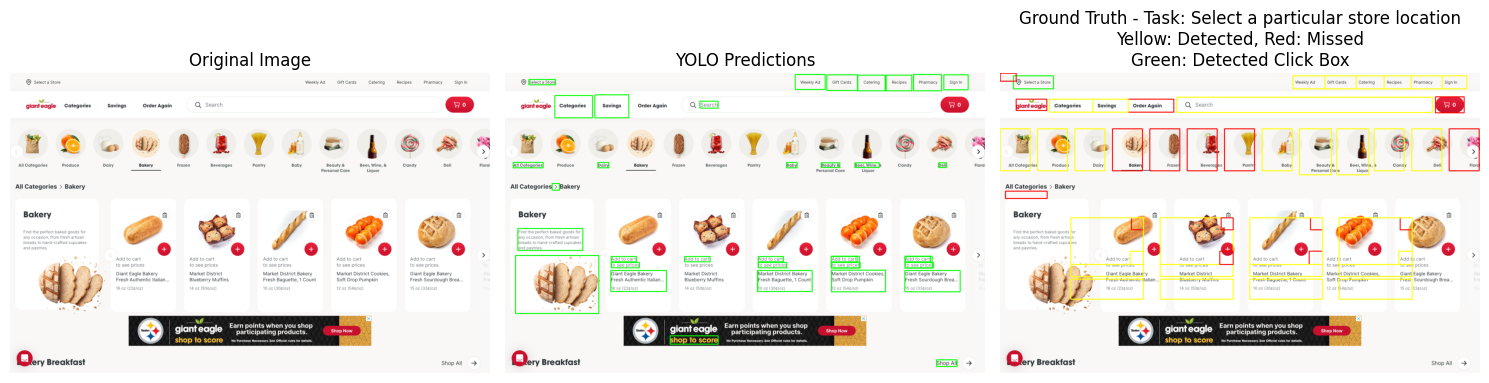

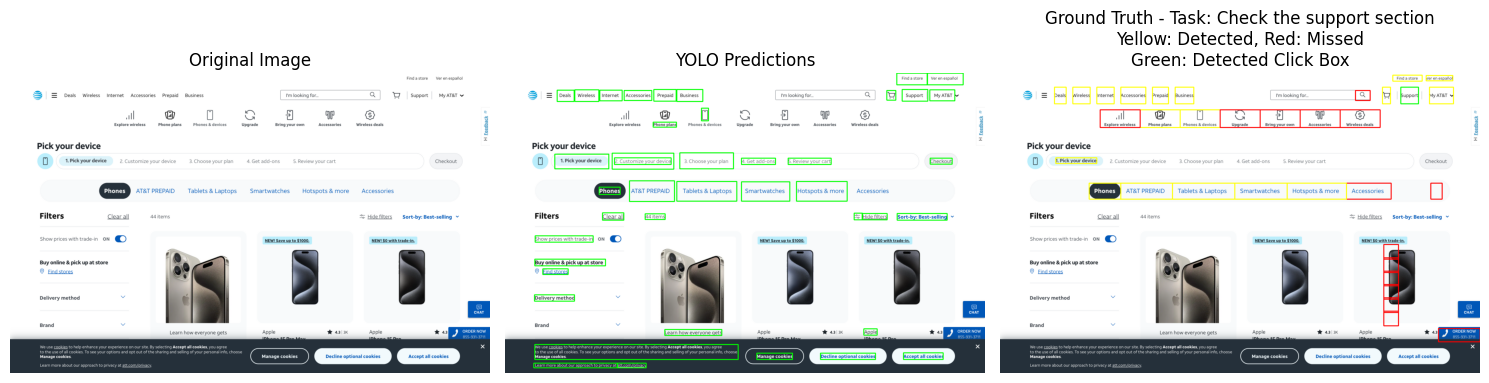

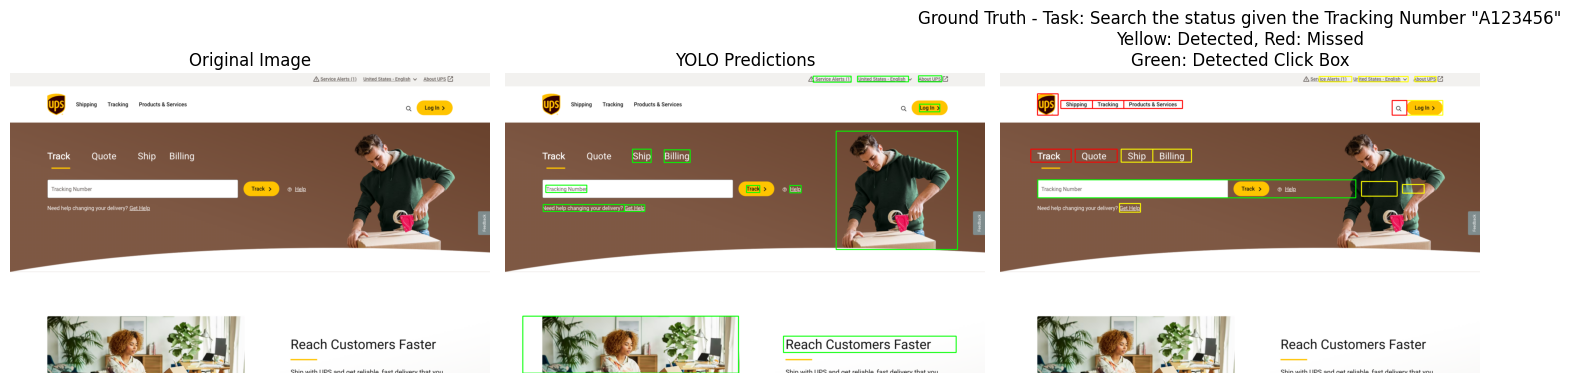

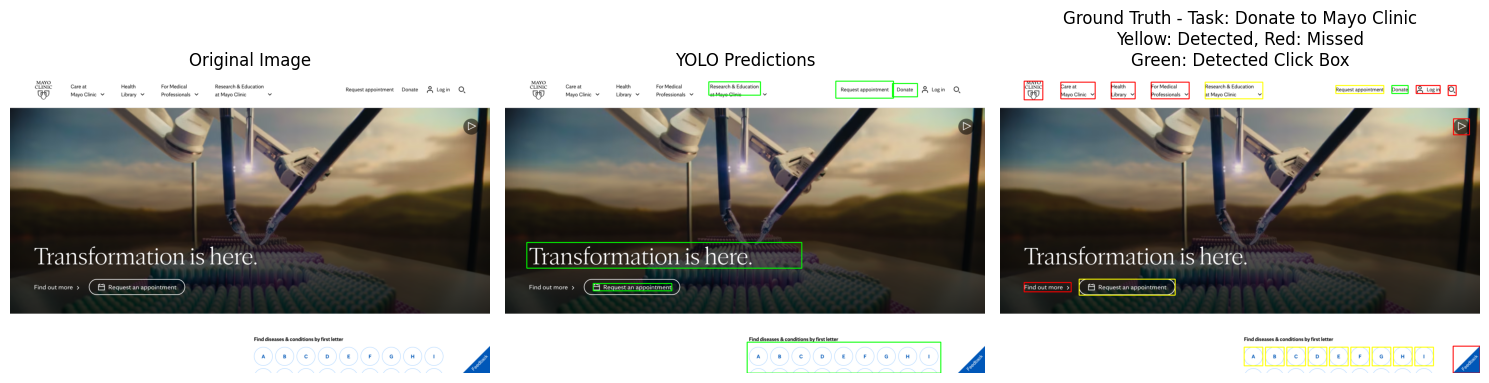

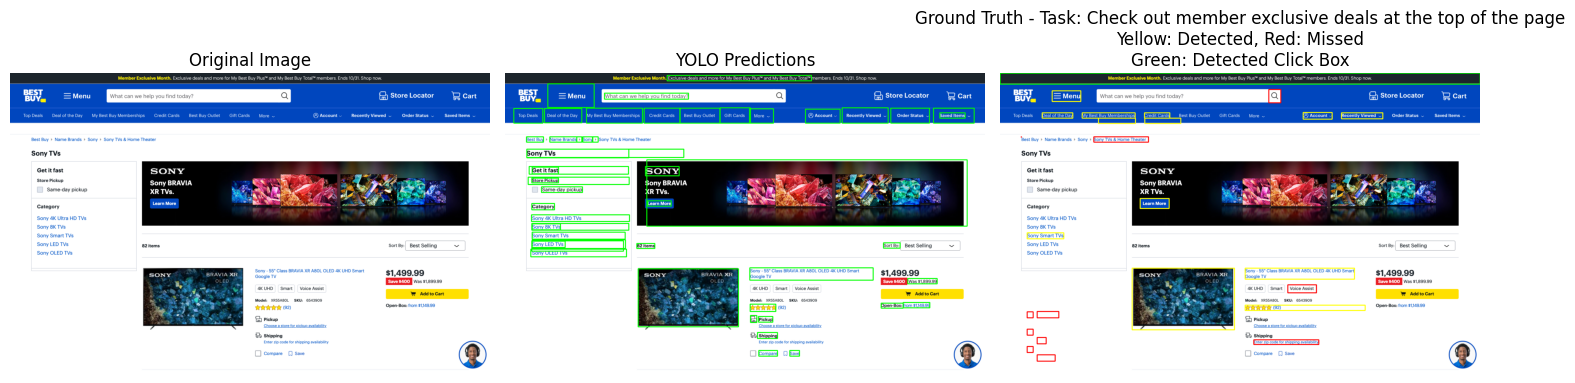

Performance Metrics:
Overall bounding box detection rate: 48.68%
Click box detection accuracy: 51.67%


In [3]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional
import random

def boxes_intersect(
    box_a: tuple[float, float, float, float],
    box_b: tuple[float, float, float, float]
) -> bool:
    """
    Check if two bounding boxes intersect.

    Parameters
    ----------
    box_a : tuple of float
        Coordinates (x1, y1, x2, y2) for the first box.
    box_b : tuple of float
        Coordinates (x1, y1, x2, y2) for the second box.

    Returns
    -------
    bool
        True if the boxes have a non-zero intersection area, False otherwise.
    """
    # Determine the coordinates of the intersection rectangle
    inter_x1 = max(box_a[0], box_b[0])
    inter_y1 = max(box_a[1], box_b[1])
    inter_x2 = min(box_a[2], box_b[2])
    inter_y2 = min(box_a[3], box_b[3])
    # An intersection exists if the width and height are both positive
    return (inter_x2 > inter_x1) and (inter_y2 > inter_y1)

def evaluate_yolo_performance(
    dataset: "pd.DataFrame",
    model_path: str = "best.pt",
    n_samples: Optional[int] = None
) -> "pd.DataFrame":
    """
    Evaluate the YOLO model's performance in detecting bounding boxes.

    Parameters
    ----------
    dataset : pd.DataFrame
        DataFrame containing screenshot paths and ground truth data
    model_path : str, optional
        Path to YOLO model weights
    n_samples : int or None, optional
        Number of random samples to evaluate

    Returns
    -------
    pd.DataFrame
        DataFrame with evaluation results and new columns
    """
    if n_samples is not None and n_samples < len(dataset):
        eval_df = dataset.sample(n=n_samples, random_state=42).reset_index(drop=True)
    else:
        eval_df = dataset.copy().reset_index(drop=True)

    try:
        model = YOLO(model_path, verbose=False)
    except Exception as e:
        print(f"Error loading YOLO model from {model_path}: {e}")
        return eval_df

    total_gt_boxes = 0
    total_detected_boxes = 0

    yolo_boxes_list: List[List[Dict]] = []
    gt_box_counts: List[int] = []
    detected_box_counts: List[int] = []
    detection_rates: List[float] = []
    click_box_detected: List[int] = []  # New list for click box detection status

    for idx, row in eval_df.iterrows():
        image_path = row["screenshot_path"]
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not load image at {image_path}. Skipping this entry.")
            yolo_boxes_list.append([])
            gt_box_counts.append(0)
            detected_box_counts.append(0)
            detection_rates.append(0.0)
            click_box_detected.append(0)
            continue

        try:
            results = model(image)[0]
        except Exception as e:
            print(f"Error during YOLO inference on image {image_path}: {e}")
            yolo_boxes_list.append([])
            gt_box_counts.append(0)
            detected_box_counts.append(0)
            detection_rates.append(0.0)
            click_box_detected.append(0)
            continue

        pred_boxes: List[Dict] = []
        if hasattr(results, "boxes") and results.boxes is not None:
            for box in results.boxes:
                coords = box.xyxy[0].tolist()
                x1, y1, x2, y2 = map(float, coords)
                pred_boxes.append({
                    "top_left": [x1, y1],
                    "bottom_right": [x2, y2]
                })
        yolo_boxes_list.append(pred_boxes)

        gt_boxes = row["bounding_boxes"]
        gt_count = len(gt_boxes)
        detected_count = 0
        click_box = row["click_box"]
        is_click_box_detected = 0

        for gt in gt_boxes:
            gt_box = (
                float(gt.get("top_left", [0, 0])[0]),
                float(gt.get("top_left", [0, 0])[1]),
                float(gt.get("bottom_right", [0, 0])[0]),
                float(gt.get("bottom_right", [0, 0])[1])
            )
            
            for pred in pred_boxes:
                pred_box = (
                    float(pred["top_left"][0]),
                    float(pred["top_left"][1]),
                    float(pred["bottom_right"][0]),
                    float(pred["bottom_right"][1])
                )
                if boxes_intersect(gt_box, pred_box):
                    detected_count += 1
                    # Check if this is the click box and it was detected
                    if gt == click_box:
                        is_click_box_detected = 1
                    break

        gt_box_counts.append(gt_count)
        detected_box_counts.append(detected_count)
        click_box_detected.append(is_click_box_detected)
        total_gt_boxes += gt_count
        total_detected_boxes += detected_count

        rate = (detected_count / gt_count * 100) if gt_count > 0 else 0.0
        detection_rates.append(rate)

    eval_df["yolo_boxes"] = yolo_boxes_list
    eval_df["gt_box_count"] = gt_box_counts
    eval_df["detected_box_count"] = detected_box_counts
    eval_df["detection_rate"] = detection_rates
    eval_df["click_box_detected"] = click_box_detected

    overall_detection_rate = (total_detected_boxes / total_gt_boxes * 100) if total_gt_boxes > 0 else 0.0
    print(f"Total ground truth boxes: {total_gt_boxes}")
    print(f"Total correctly detected boxes: {total_detected_boxes}")
    print(f"Overall detection rate: {overall_detection_rate:.2f}%")

    return eval_df

def visualize_random_samples(evaluated_df: "pd.DataFrame", n_samples: int = 3) -> None:
    """
    Visualize random samples from the evaluated dataset showing original image,
    YOLO predictions, and ground truth boxes with detection status.

    Parameters
    ----------
    evaluated_df : pd.DataFrame
        DataFrame output from evaluate_yolo_performance
    n_samples : int, optional
        Number of random samples to visualize
    """
    random.seed(42)
    sample_indices = random.sample(range(len(evaluated_df)), min(n_samples, len(evaluated_df)))
    
    for idx in sample_indices:
        row = evaluated_df.iloc[idx]
        image_path = row["screenshot_path"]
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create three copies of the image for different visualizations
        img_original = image.copy()
        img_yolo = image.copy()
        img_ground_truth = image.copy()
        
        # Draw YOLO boxes
        for box in row["yolo_boxes"]:
            pt1 = (int(box["top_left"][0]), int(box["top_left"][1]))
            pt2 = (int(box["bottom_right"][0]), int(box["bottom_right"][1]))
            cv2.rectangle(img_yolo, pt1, pt2, (0, 255, 0), 2)
            
        # Draw ground truth boxes
        for box in row["bounding_boxes"]:
            pt1 = (int(box["top_left"][0]), int(box["top_left"][1]))
            pt2 = (int(box["bottom_right"][0]), int(box["bottom_right"][1]))
            
            # Check if this box was correctly detected
            box_tuple = (
                float(box["top_left"][0]),
                float(box["top_left"][1]),
                float(box["bottom_right"][0]),
                float(box["bottom_right"][1])
            )
            
            is_detected = False
            for yolo_box in row["yolo_boxes"]:
                yolo_tuple = (
                    float(yolo_box["top_left"][0]),
                    float(yolo_box["top_left"][1]),
                    float(yolo_box["bottom_right"][0]),
                    float(yolo_box["bottom_right"][1])
                )
                if boxes_intersect(box_tuple, yolo_tuple):
                    is_detected = True
                    break
            
            # Yellow if detected, red if not
            color = (255, 255, 0) if is_detected else (255, 0, 0)
            
            # Green if this is the click box and it was detected
            if box == row["click_box"]:
                color = (0, 255, 0) if row["click_box_detected"] else (255, 0, 0)
                
            cv2.rectangle(img_ground_truth, pt1, pt2, color, 2)
        
        # Display the images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(img_original)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        axes[1].imshow(img_yolo)
        axes[1].set_title("YOLO Predictions")
        axes[1].axis("off")
        
        axes[2].imshow(img_ground_truth)
        axes[2].set_title(f"Ground Truth - Task: {row['task']}\nYellow: Detected, Red: Missed\nGreen: Detected Click Box")
        axes[2].axis("off")
        
        plt.tight_layout()
        plt.show()

def show_performance_metrics(evaluated_df: "pd.DataFrame") -> None:
    """
    Display overall performance metrics for the evaluated dataset.

    Parameters
    ----------
    evaluated_df : pd.DataFrame
        DataFrame output from evaluate_yolo_performance
    """
    total_boxes = evaluated_df["gt_box_count"].sum()
    total_detected = evaluated_df["detected_box_count"].sum()
    overall_detection_rate = (total_detected / total_boxes * 100) if total_boxes > 0 else 0
    
    click_box_accuracy = evaluated_df["click_box_detected"].mean() * 100
    
    print("Performance Metrics:")
    print(f"Overall bounding box detection rate: {overall_detection_rate:.2f}%")
    print(f"Click box detection accuracy: {click_box_accuracy:.2f}%")

# Example usage:
evaluated_df = evaluate_yolo_performance(df_data, model_path="best.pt", n_samples=60)
print(evaluated_df.head())
visualize_random_samples(evaluated_df, n_samples=5)
show_performance_metrics(evaluated_df)


In [7]:
import google.generativeai as genai
from PIL import Image

def visualize_predictions(
    image,
    results,
    class_names: Dict[int, str],
    conf_threshold: float = 0.25,
    figsize: Tuple[int, int] = (12, 8),
    show_labels: bool = True,
    use_numeric_labels: bool = False,
    show_conf: bool = True,
    font_size: int = 10,
    selected_box: Optional[int] = None,
    box_opacity: float = 0.3,
    label_opacity: float = 0.8
) -> Tuple[plt.Figure, List[Dict], np.ndarray]:
    """Visualize model predictions on the image."""
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a copy of the image for drawing boxes
    image_with_boxes = image.copy()
    
    # Display image
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Store box information for Gemini
    boxes_info = []
    
    # Draw predicted boxes
    for idx, box in enumerate(results.boxes, 1):  # Start counting from 1
        if box.conf.item() < conf_threshold:
            continue
            
        # Get coordinates and class
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        conf = box.conf.item()
        cls = int(box.cls.item())
        class_name = class_names.get(cls, f"unknown_{cls}")
        
        # Store box information
        boxes_info.append({
            "id": idx,
            "class": class_name,
            "confidence": conf,
            "coords": [x1, y1, x2, y2]
        })
        
        # Determine box color (green if selected, red otherwise)
        box_color = 'green' if idx == selected_box else 'red'
        box_color_bgr = (0, 255, 0) if idx == selected_box else (0, 0, 255)
        
        # Draw on matplotlib figure
        rect_fill = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=True, 
                                color=box_color, alpha=box_opacity)
        rect_border = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, 
                                  color=box_color, linewidth=2)
        ax.add_patch(rect_fill)
        ax.add_patch(rect_border)
        
        # Draw on image copy
        cv2.rectangle(image_with_boxes, (int(x1), int(y1)), (int(x2), int(y2)), 
                     box_color_bgr, 2)
        
        # Add label with confidence if enabled
        if show_labels:
            if use_numeric_labels:
                label_text = f"#{idx}"
            else:
                label_text = class_name
                
            if show_conf:
                label_text += f" {conf:.2f}"
            
            # Add label to matplotlib figure    
            ax.text(x1, y1-5, label_text, color=box_color, fontsize=font_size, 
                    bbox=dict(facecolor='white', alpha=label_opacity, edgecolor=box_color, pad=2))
            
            # Add label to image copy
            cv2.putText(image_with_boxes, label_text, (int(x1), int(y1)-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color_bgr, 2)
    
    # Remove axes
    ax.axis('off')
    plt.tight_layout()
    
    return fig, boxes_info, image_with_boxes

def evaluate_gemini_predictions(
    evaluated_df: "pd.DataFrame",
    n_samples: int,
    model_path: str = "best.pt",
    gemini_api_key: Optional[str] = None,
    verbose: bool = False
) -> "pd.DataFrame":
    """
    Evaluate Gemini's ability to select the correct bounding box for a given task.
    
    Parameters
    ----------
    evaluated_df : pd.DataFrame
        DataFrame with evaluation results from evaluate_yolo_performance
    n_samples : int
        Number of samples to evaluate (will use as random seed too)
    model_path : str, optional
        Path to YOLO model weights
    gemini_api_key : str, optional
        Gemini API key. If None, will try to get from environment variable
    verbose : bool, optional
        If True, print prediction details during evaluation
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added columns for Gemini prediction accuracy, explanation, YOLO visualization
        and selected bounding box
    """
    # Configure Gemini
    if gemini_api_key is None:
        gemini_api_key = os.getenv("GEMINI_API_KEY")
    if not gemini_api_key:
        raise ValueError("Please provide GEMINI_API_KEY either directly or via environment variable")
        
    genai.configure(api_key=gemini_api_key)
    model = genai.GenerativeModel('gemini-2.0-flash-thinking-exp')
    
    # Filter for rows where click box was detected and sample from those
    detected_df = evaluated_df[evaluated_df["click_box_detected"] == 1]
    np.random.seed(n_samples)
    sample_df = detected_df.sample(n=n_samples).copy()
    
    # Load YOLO model
    yolo_model = YOLO(model_path)
    
    gemini_correct = []
    gemini_explanations = []
    yolo_visualizations = []
    gemini_boxes = []
    
    for idx, row in sample_df.iterrows():
        if verbose:
            print(f"\nProcessing sample {idx + 1}/{n_samples}")
            print(f"Task: {row['task']}")
            
        # Load and process original image
        image = cv2.imread(row["screenshot_path"])
        if image is None:
            print(f"Could not load image: {row['screenshot_path']}")
            gemini_correct.append(0)
            gemini_explanations.append("Error: Could not load image")
            yolo_visualizations.append(None)
            gemini_boxes.append(None)
            continue
            
        # Get YOLO predictions
        results = yolo_model(image)[0]
        
        # Create image with numbered boxes for Gemini
        fig, boxes_info, image_with_boxes = visualize_predictions(
            image,
            results,
            {}, # Class names not needed since we're using numeric labels
            show_labels=True,
            use_numeric_labels=True,
            show_conf=False,
            font_size=10
        )
        plt.close(fig)  # Close the figure to free memory
        
        # Store the visualization
        yolo_visualizations.append(image_with_boxes)
        
        # Create simplified prompt without zoom functionality
        prompt = f"""Task to complete: "{row['task']}"

Available UI elements detected in the image (Bounding Boxes):
{chr(10).join(f"Box #{box['id']}" for box in boxes_info)}

Analysis Instructions:
1. First, understand what UI element we need to interact with based on the task
2. Look for the element in the detected boxes
3. Select the box number that best matches the task requirements

Response Format:
'Box #X - This element matches the task because [reason]'

If no suitable box is found:
'No suitable box - [explanation why]'

Please analyze the task and detected elements carefully, then provide a single, clear response following the format above."""

        try:
            # Get Gemini's prediction
            response = model.generate_content([prompt, 
                                            Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)),
                                            Image.fromarray(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))])
            
            response_text = response.text
            gemini_explanations.append(response_text)
            
            if verbose:
                print("\nGemini's response:")
                print(response_text)
            
            # Extract predicted box number
            if "No suitable box" in response_text:
                predicted_box = None
                gemini_boxes.append(None)
            else:
                predicted_box = int(response_text.split("#")[1].split(" ")[0])
                # Store the predicted box coordinates
                pred_box = boxes_info[predicted_box - 1]["coords"]  # -1 because box IDs start at 1
                gemini_boxes.append(pred_box)
                
            # Check if prediction is correct
            if predicted_box is not None:
                pred_box_tuple = tuple(pred_box)
                
                # Get ground truth click box coordinates
                click_box = row["click_box"]
                gt_box_tuple = (
                    float(click_box["top_left"][0]),
                    float(click_box["top_left"][1]), 
                    float(click_box["bottom_right"][0]),
                    float(click_box["bottom_right"][1])
                )
                
                # Check if boxes intersect
                is_correct = boxes_intersect(pred_box_tuple, gt_box_tuple)
                gemini_correct.append(1 if is_correct else 0)
                
                if verbose:
                    print(f"Prediction correct: {is_correct}")
            else:
                gemini_correct.append(0)
                if verbose:
                    print("Prediction incorrect: No box selected")
                
        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            gemini_correct.append(0)
            gemini_explanations.append(f"Error: {str(e)}")
            gemini_boxes.append(None)
    
    sample_df["gemini_correct"] = gemini_correct
    sample_df["gemini_explanation"] = gemini_explanations
    sample_df["yolo_visualization"] = yolo_visualizations
    sample_df["gemini_box"] = gemini_boxes
    
    # Print summary statistics
    accuracy = np.mean(gemini_correct) * 100
    print(f"\nGemini Prediction Results:")
    print(f"Samples evaluated: {n_samples}")
    print(f"Accuracy: {accuracy:.2f}%")
    
    return sample_df

# Example usage:
sample_results = evaluate_gemini_predictions(evaluated_df, n_samples=20, verbose=True)
print("\nSample results:")
print(sample_results[["task", "gemini_correct", "gemini_explanation", "yolo_visualization", "gemini_box"]].head())


Processing sample 54/20
Task: Click on the sign in button to access your account quickly

0: 800x1280 27 StaticTexts, 4 StaticText_gridcells, 4 StaticText_headings, 9 StaticText_links, 6 StaticText_link_listitems, 1 StaticText_paragraph, 1376.7ms
Speed: 12.3ms preprocess, 1376.7ms inference, 3.5ms postprocess per image at shape (1, 3, 800, 1280)

Gemini's response:
Response:
Box #9 - This element matches the task because it is the "Sign in" button, which is exactly what the task requires to be clicked.
Prediction correct: False

Processing sample 34/20
Task: Check Flight Aware live flight delay and cancellation statistics for today

0: 800x1280 9 StaticTexts, 1 StaticText_button, 3 StaticText_headings, 1 StaticText_link_heading, 9 StaticText_link_listitems, 1226.8ms
Speed: 5.6ms preprocess, 1226.8ms inference, 3.1ms postprocess per image at shape (1, 3, 800, 1280)

Gemini's response:
Response:
Box #13 - This element matches the task because it directly displays the "Total delays today

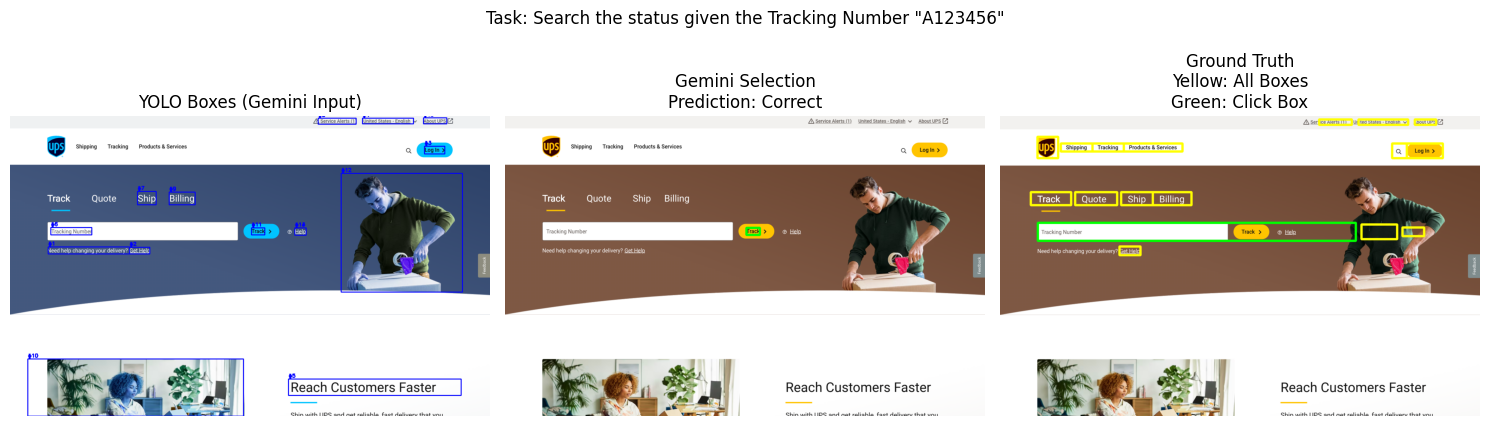

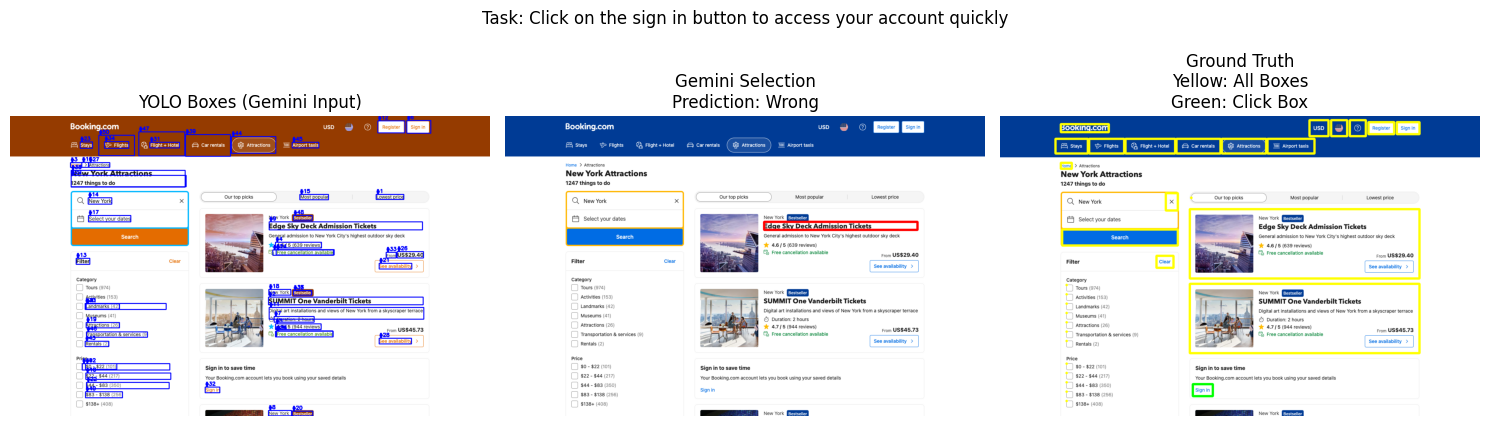

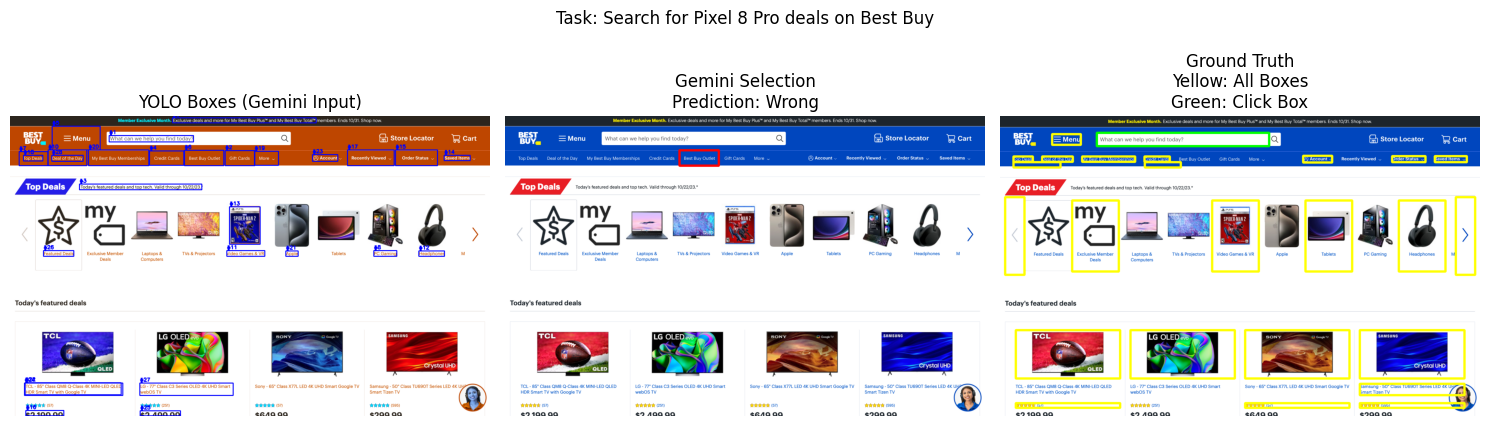

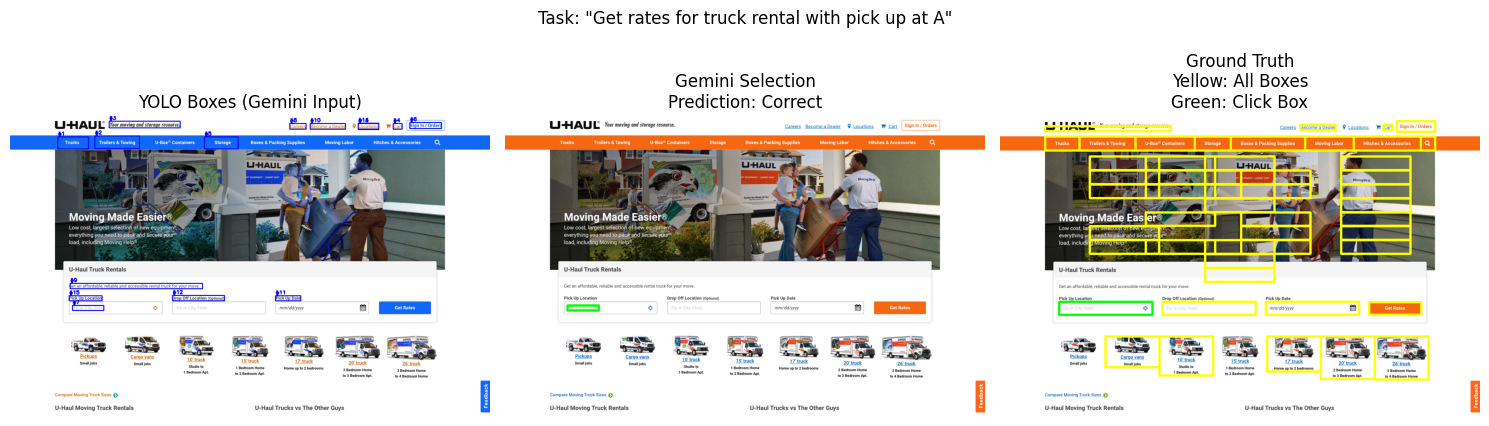

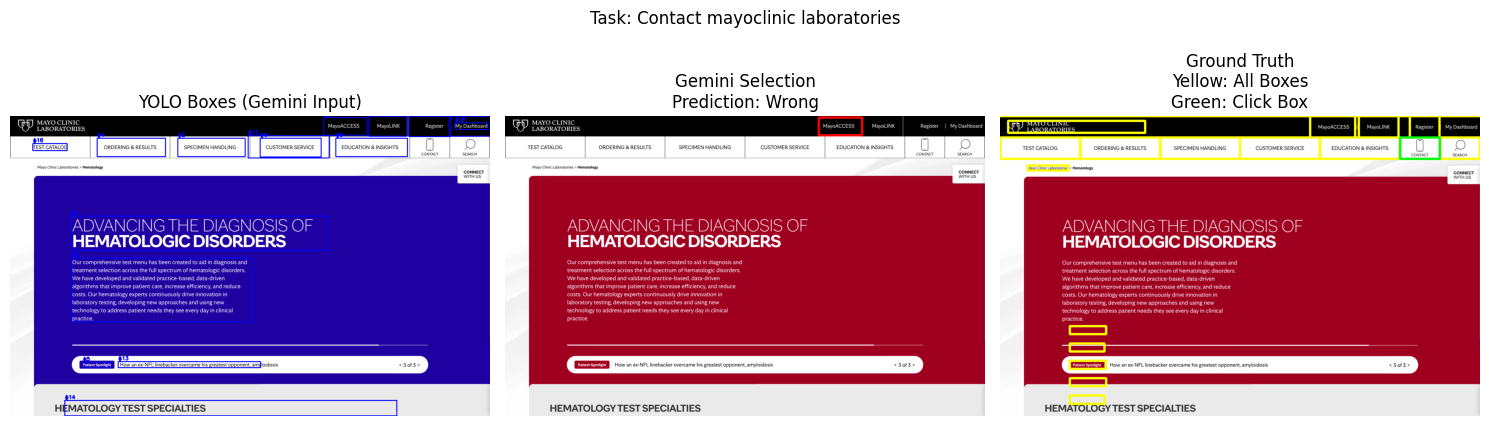

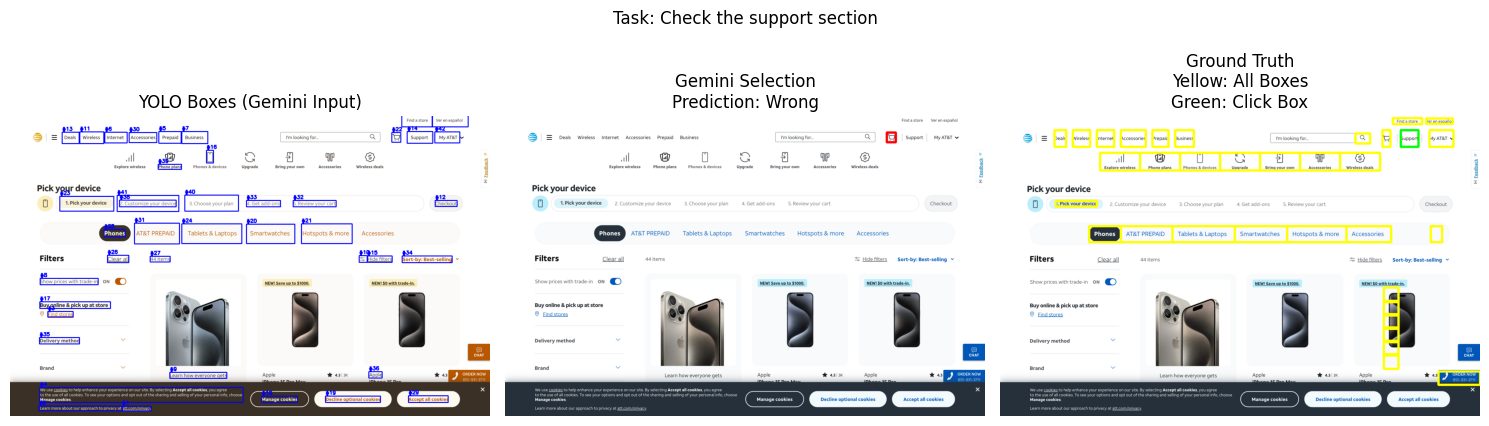

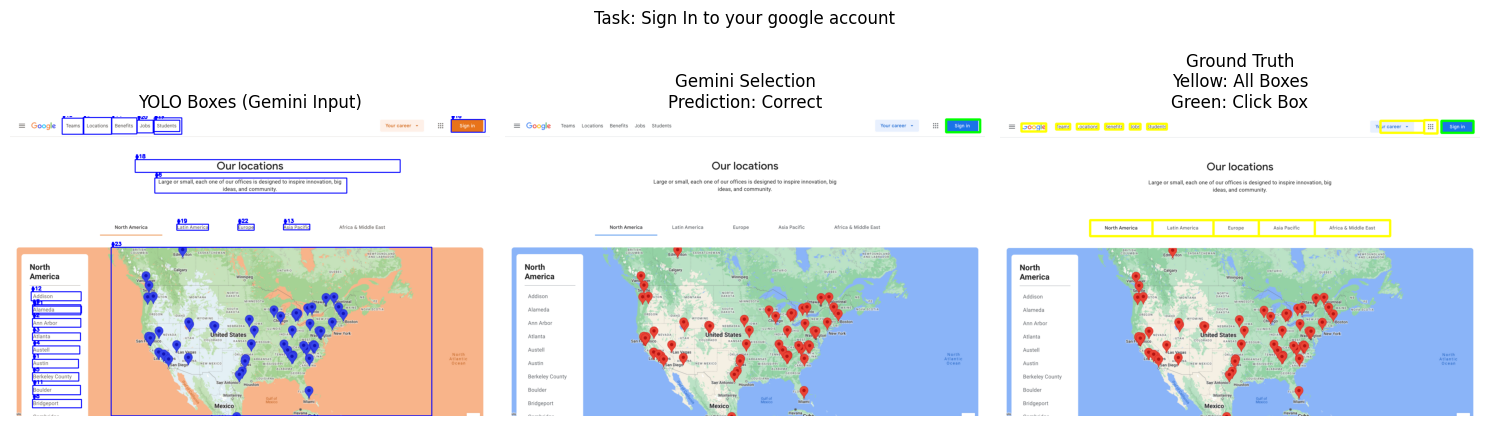

In [9]:
def visualize_gemini_samples(dataset: "pd.DataFrame", n_samples: int = 3) -> None:
    """
    Visualize random samples from the dataset showing:
    1. Image with YOLO boxes used as Gemini input
    2. Image with Gemini's selected box highlighted
    3. Image with ground truth boxes and click box

    Parameters
    ----------
    dataset : pd.DataFrame
        DataFrame containing evaluation results
    n_samples : int, optional
        Number of random samples to visualize
    """
    random.seed(42)
    sample_indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
    
    for idx in sample_indices:
        row = dataset.iloc[idx]
        image_path = row["screenshot_path"]
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create three copies of the image for different visualizations
        img_yolo = row["yolo_visualization"]  # Already contains YOLO boxes with labels
        
        # Create image with Gemini's selected box
        img_gemini = image.copy()
        if row["gemini_box"] is not None:
            box = row["gemini_box"]
            pt1 = (int(box[0]), int(box[1]))
            pt2 = (int(box[2]), int(box[3]))
            # Thicker border (5px) and color based on correctness
            color = (0, 255, 0) if row['gemini_correct'] else (255, 0, 0)  # Green if correct, red if wrong
            cv2.rectangle(img_gemini, pt1, pt2, color, 5)  # Increased thickness to 5
            
        # Create image with ground truth boxes and click box
        img_ground_truth = image.copy()
        
        # Draw all ground truth boxes in yellow with thicker border
        for box in row["bounding_boxes"]:
            pt1 = (int(box["top_left"][0]), int(box["top_left"][1]))
            pt2 = (int(box["bottom_right"][0]), int(box["bottom_right"][1]))
            cv2.rectangle(img_ground_truth, pt1, pt2, (255, 255, 0), 5)  # Yellow, thicker border
            
        # Draw click box in green with thicker border
        click_box = row["click_box"]
        pt1 = (int(click_box["top_left"][0]), int(click_box["top_left"][1]))
        pt2 = (int(click_box["bottom_right"][0]), int(click_box["bottom_right"][1]))
        cv2.rectangle(img_ground_truth, pt1, pt2, (0, 255, 0), 5)  # Green, thicker border
        
        # Display the images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(img_yolo)
        axes[0].set_title("YOLO Boxes (Gemini Input)")
        axes[0].axis("off")
        
        # Add prediction status to Gemini visualization title
        prediction_status = "Correct" if row['gemini_correct'] else "Wrong"
        axes[1].imshow(img_gemini)
        axes[1].set_title(f"Gemini Selection\nPrediction: {prediction_status}")
        axes[1].axis("off")
        
        axes[2].imshow(img_ground_truth)
        axes[2].set_title("Ground Truth\nYellow: All Boxes\nGreen: Click Box")
        axes[2].axis("off")
        
        plt.suptitle(f"Task: {row['task']}", wrap=True)
        plt.tight_layout()
        plt.show()

# Example usage:
visualize_gemini_samples(sample_results, n_samples=7)
